In [61]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from os.path import join
import matplotlib as mpl
import pandas as pd
mpl.style.use('../../style.mcstyle')   # noqa
import seaborn as sns
from tqdm import tqdm

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [65]:
wdir = '/anvil/scratch/x-mho1/cmass-ili/quijote/nbody/models/halo/zPk0/kmin-0.0_kmax-0.4'

kmin, kmax = 0.0, 0.4
summ = 'zPk0'

x_train = np.load(join(wdir, 'x_train.npy'))
theta_train = np.load(join(wdir, 'theta_train.npy'))

wdir = '/anvil/scratch/x-mho1/cmass-ili/abacus1gpch/custom/models/halo/zPk0/kmin-0.0_kmax-0.4'
x_test = np.load(join(wdir, 'x_test.npy'))
theta_test = np.load(join(wdir, 'theta_test.npy'))
ids_test = np.load(join(wdir, 'ids_test.npy'))

yrange = np.stack([
    theta_train.min(axis=0),
    theta_train.max(axis=0)
], axis=1)

print('Len(train):', len(x_train))
print('Len(test):', len(x_test))

Len(train): 1600
Len(test): 119


## Examine abacus cosmologies

In [16]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
tabpath = join(wdir, 'scratch', 'abacus_custom_table.csv')
cosm = pd.read_csv(tabpath)

Omega_m = cosm['omega_cdm'] + cosm['omega_b'] + cosm['omega_ncdm']
Omega_b = cosm['omega_b']
h = cosm['h']
n_s = cosm['n_s']
sigma8 = cosm['sigma8_m']

# rescale to capital Omega
Omega_m /= h**2
Omega_b /= h**2

idx_lcdm = np.argwhere(cosm['LCDM'] == 'y').flatten().tolist()
idx_mnu = np.argwhere(cosm['Massive Neutrinos'] == 'y').flatten().tolist()
idx_simple = list(set(idx_lcdm) - set(idx_mnu))

print('LCDM:', idx_lcdm)
print('Mnu>0:', idx_mnu)
print('LCDM & Mnu=0:', idx_simple)

# cosm

LCDM: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 54, 55, 56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
Mnu>0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
LCDM & Mnu=0: [32, 34, 35, 36, 37, 38, 40, 30, 31]


## Generate p(x|theta)

In [3]:
x = theta_train
theta = x_train

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=[-1000.]*theta.shape[-1], high=[1000.]*theta.shape[-1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf',
                           hidden_features=16, num_transforms=4),
    ili.utils.load_nde_sbi(engine='NPE', model='made',
                           hidden_features=16, num_transforms=4),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [4]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 140

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 127141 epochs.

INFO:root:It took 157.09173893928528 seconds to train models.


 Neural network successfully converged after 128 epochs.

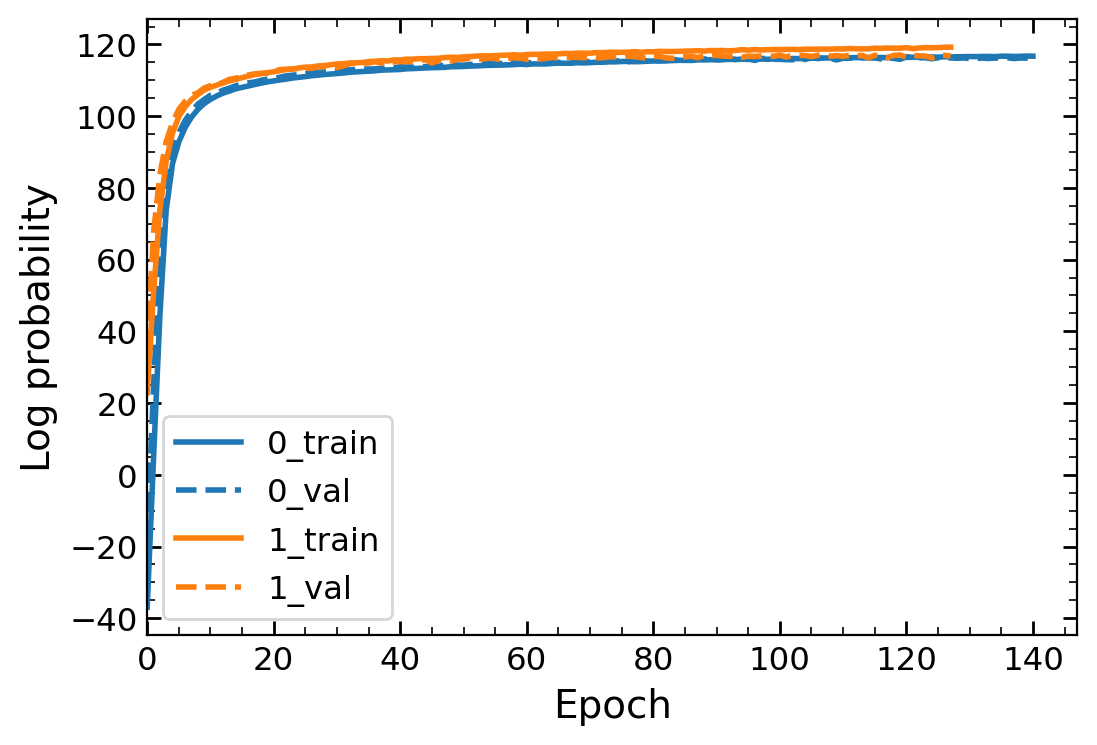

In [5]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 653 posterior samples: 100%|██████████| 653/653 [00:00<00:00, 2355.21it/s]


Text(0.5, 0.98, 'LCDM & Mnu=0')

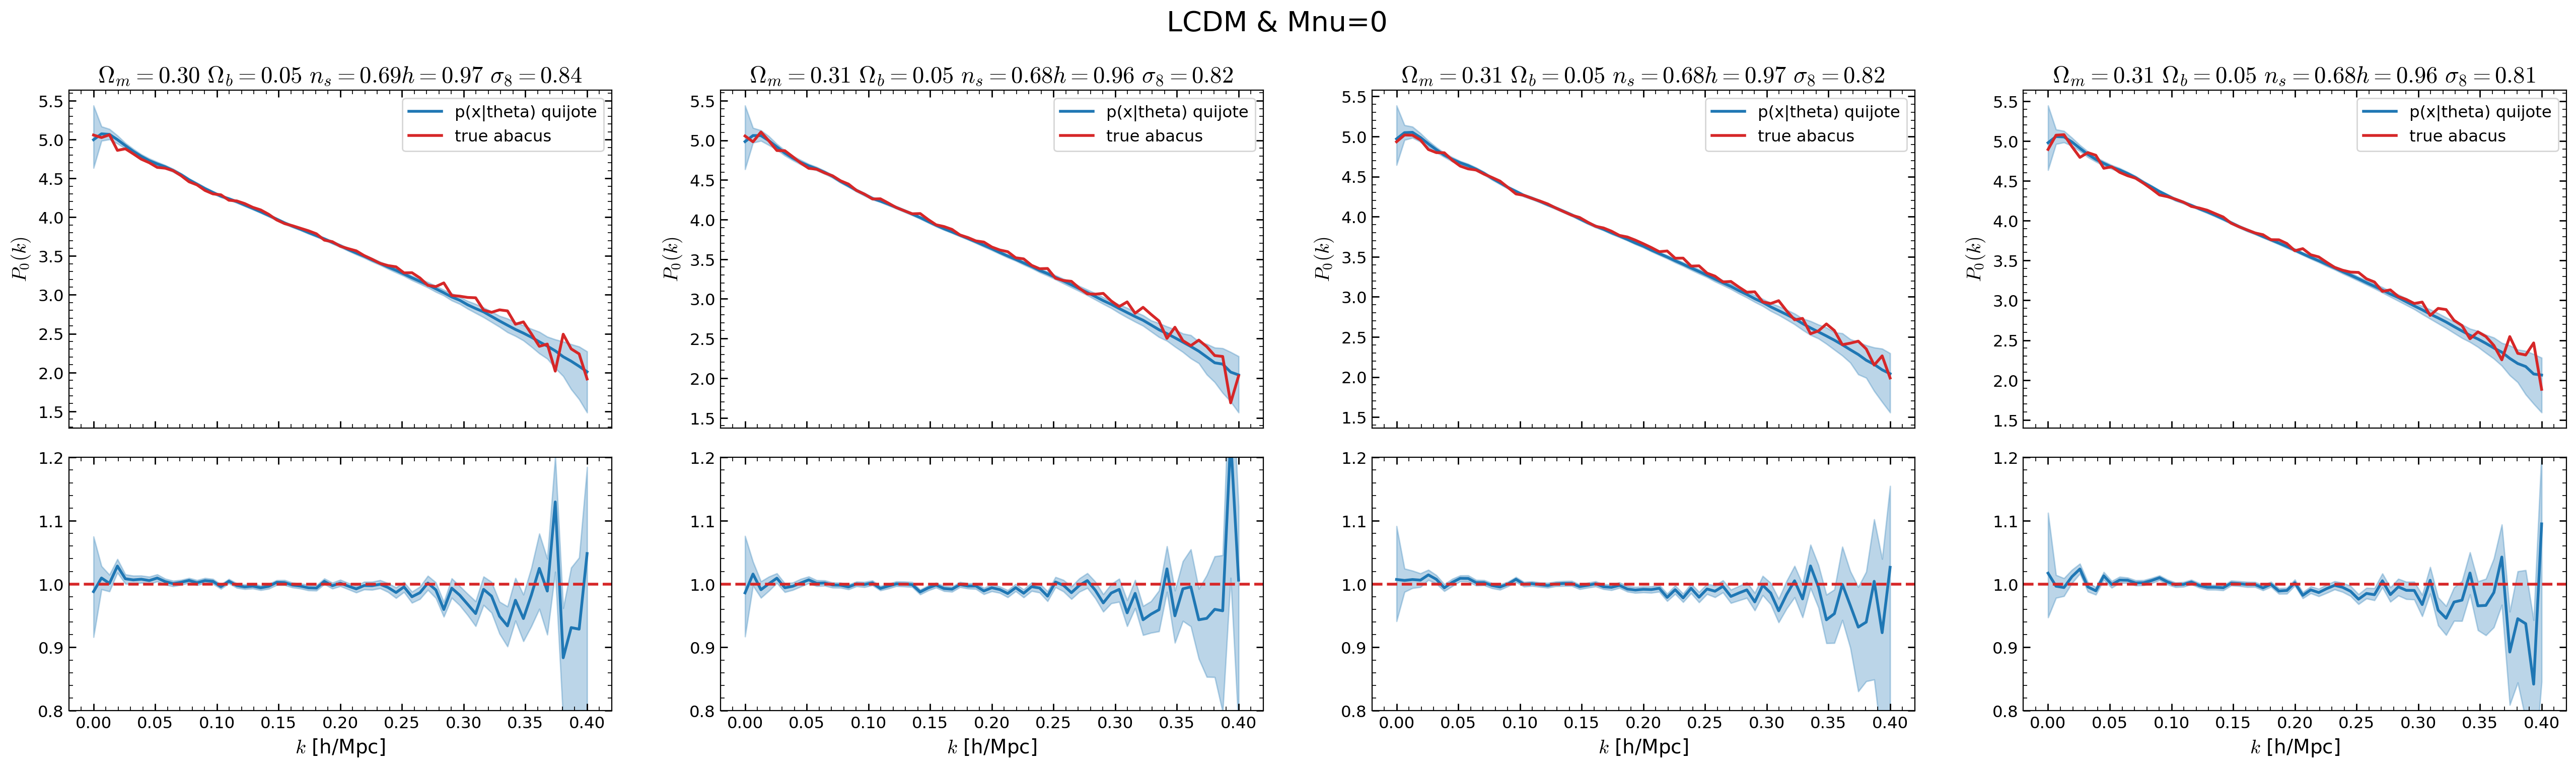

In [37]:
Nsamp = 4


f, axs = plt.subplots(2, Nsamp, figsize=(8*Nsamp, 8),
                      gridspec_kw={
    'height_ratios': [1, 0.75],
    'hspace': 0.1},
    sharex=True, sharey=False)

inds = np.random.choice(idx_simple, Nsamp, replace=False).astype(int)

for i, ind in enumerate(inds):
    # generate samples from the posterior using MCMC
    samples = posterior_ensemble.sample(
        (1000,), theta_test[ind],
    ).detach().cpu().numpy()

    ax = axs[0, i]
    y_ = x_test[ind]
    x_ = np.linspace(0, 0.4, samples.shape[-1])
    percs = np.percentile(samples, [50, 16, 84], axis=0)
    ax.plot(x_, percs[0], c='C0', label=r'p(x|theta) quijote')
    ax.fill_between(
        x_, percs[1], percs[2], color='C0', alpha=0.3)
    ax.plot(x_, y_, c='C3', label='true abacus')
    # ax.set_xlabel('$k$ [h/Mpc]')
    ax.set_ylabel('$P_0(k)$')
    ax.legend()
    ax.set_title(
        f'$\Omega_m={theta_test[ind,0]:.2f}$ '
        f'$\Omega_b={theta_test[ind,1]:.2f}$ '
        f'$n_s={theta_test[ind,2]:.2f}$'
        f'$h={theta_test[ind,3]:.2f}$ '
        f'$\sigma_8={theta_test[ind,4]:.2f}$ ')

    ax = axs[1, i]
    ax.plot(x_, percs[0]/y_, c='C0', label=r'p(x|theta) quijote')
    ax.fill_between(
        x_, percs[1]/y_, percs[2]/y_, color='C0', alpha=0.3)
    ax.axhline(1, ls='--', c='C3')
    ax.set_xlabel('$k$ [h/Mpc]')
    ax.set_ylim(0.8, 1.2)

f.suptitle('LCDM & Mnu=0', fontsize=20)

## Sample P(theta|x) with NLE

In [38]:
x = x_train
theta = theta_train

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0), high=theta.max(axis=0), device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf',
                           hidden_features=16, num_transforms=4),
    ili.utils.load_nde_sbi(engine='NLE', model='made',
                           hidden_features=16, num_transforms=4),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model. this outputs a posterior model and training logs
posterior, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 162

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 133163 epochs.

INFO:root:It took 162.49796652793884 seconds to train models.


 Neural network successfully converged after 134 epochs.

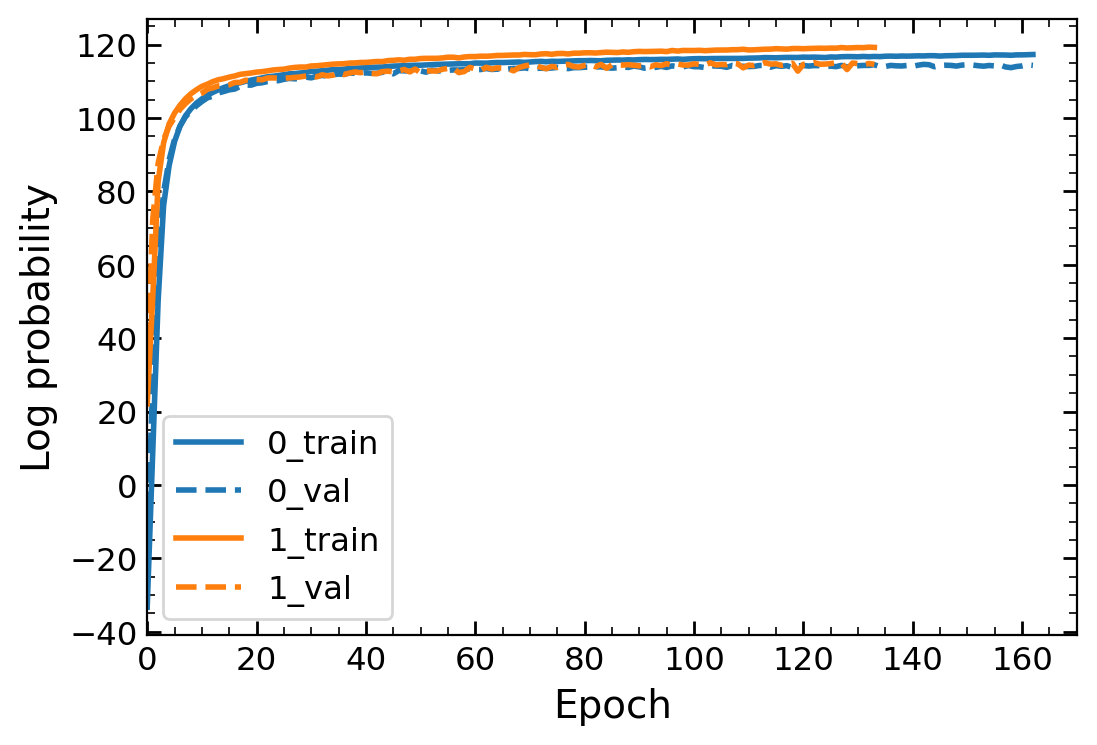

In [59]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [60]:
names = ['Omega_m', 'Omega_b', 'n_s', 'h', 'sigma8']

# Predict on a random test point
ind = 15
x0 = torch.Tensor(x_test[ind]).to(device)
y0 = theta_test[ind]
samp0 = posterior.sample(
    x=x0, sample_shape=(1000,),
    method='slice_np_vectorized',
    num_chains=6,)
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)
plot_true_vals(g, y0, color='r', lw=1)

Running vectorized MCMC with 6 chains: 100%|█████████▉| 6600/6630 [01:05<00:00, 100.30it/s]


In [64]:
# Predict on a suite of summaries
xobs = x_test
yobs = theta_test

samps, trues = [], []
for ind in tqdm(idx_simple):
    xin = torch.Tensor(xobs[ind]).to(device)
    samp = posterior.sample(
        x=xin, sample_shape=(200,),
        method='slice_np_vectorized',
        num_chains=16,
        show_progress_bars=False).to('cpu')
    samps.append(samp)
    trues.append(theta_test[ind])
samps = np.array(samps)
trues = np.array(trues)

100%|██████████| 9/9 [06:58<00:00, 46.50s/it]


Text(0.5, 0.98, 'zPk0, $k\\in[0.0,0.4]$, w/o prior correction')

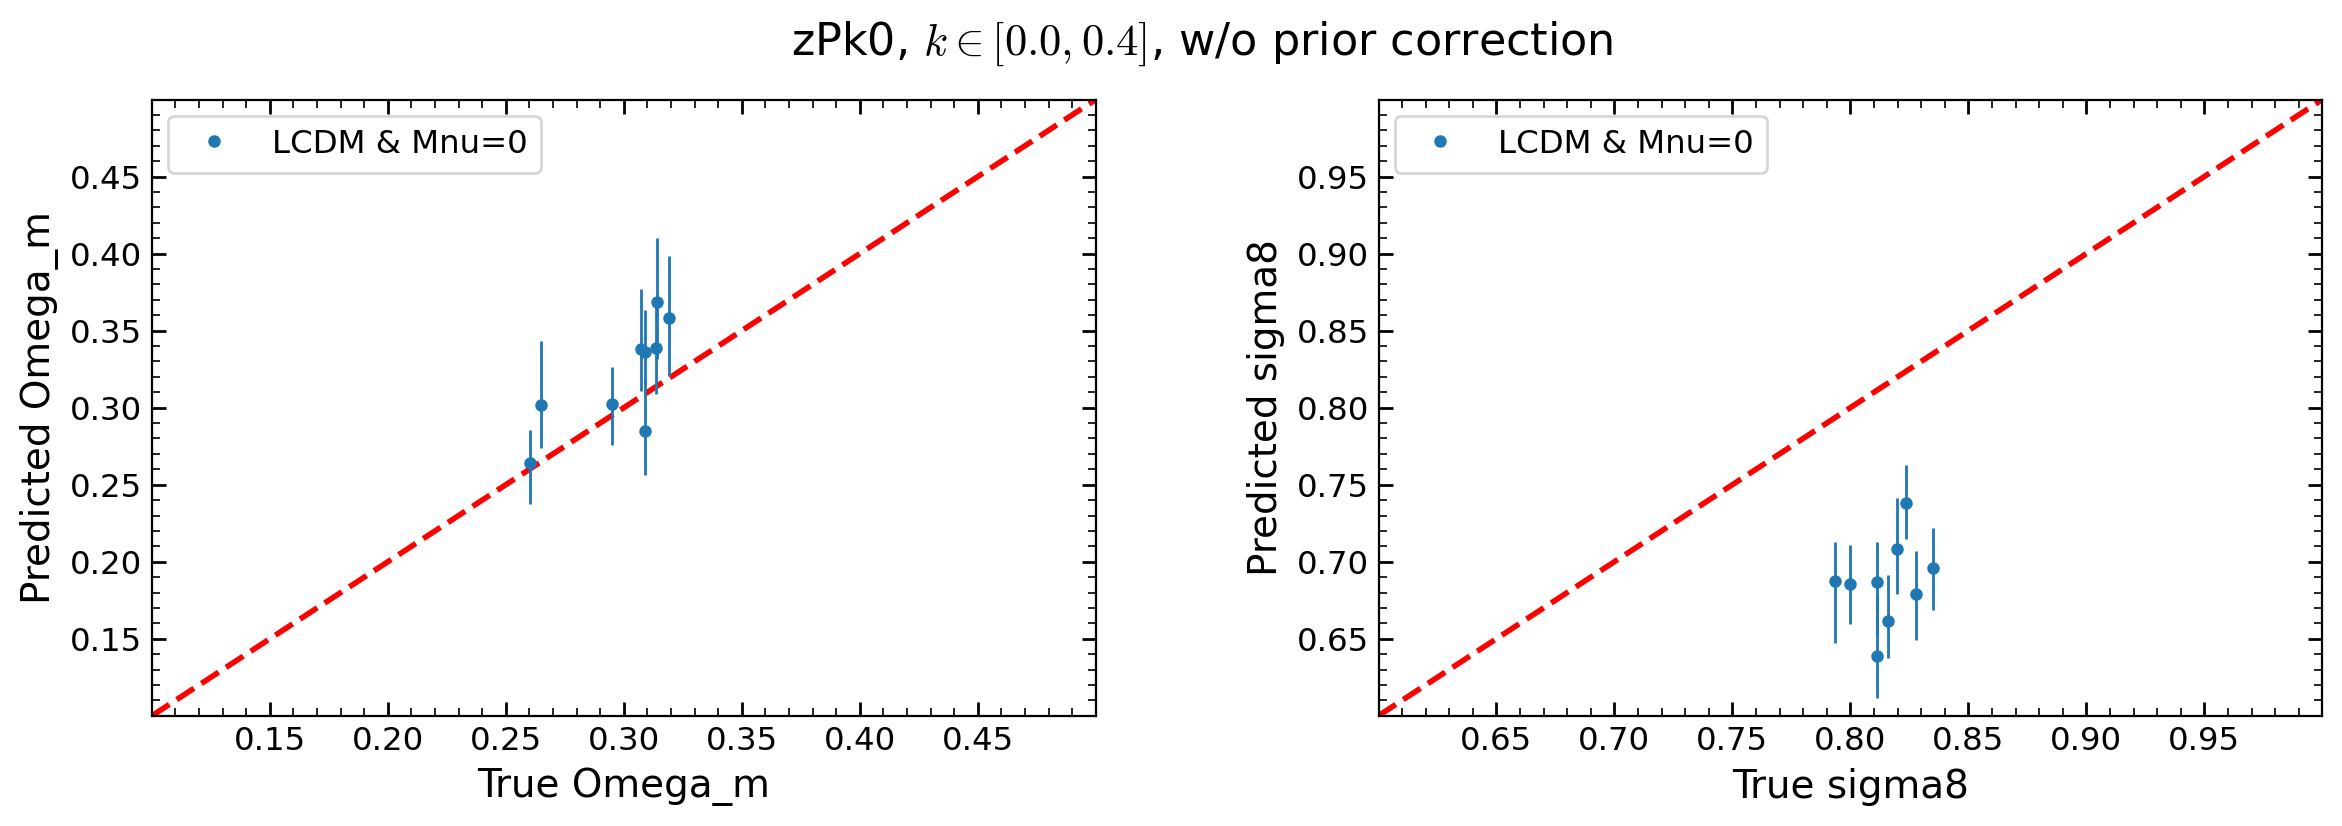

In [66]:
H, W = 1, 2
f, axs = plt.subplots(H, W, figsize=(7*W, 4*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()


for j, i in enumerate([0, 4]):
    ax = axs[j]
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.set_xlim(yrange[i])
    ax.set_ylim(yrange[i])
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
    percs = np.percentile(samps[:, :, i], [50, 16, 84], axis=1)
    ax.plot(trues[:, i], percs[0], '.',
            color=f'C{0}', markersize=7, label='LCDM & Mnu=0')
    ax.errorbar(trues[:, i], percs[0], yerr=[percs[0]-percs[1],
                percs[2]-percs[0]], fmt='none', color=f'C0', elinewidth=1)
    ax.legend()

f.suptitle(
    summ + f', $k\in[{kmin},{kmax}]$,'
    ' w/o prior correction',
    fontsize=16)

In [43]:
posterior_ensemble

NeuralPosteriorEnsemble sampler for potential_fn=<EnsemblePotential>